In [1]:
import pandas as pd


In [2]:
# !wget https://raw.githubusercontent.com/ZeoVan/MSR_20_Code_vulnerability_CSV_Dataset/master/all_c_cpp_release2.0.csv
df = pd.read_csv("all_c_cpp_release2.0.csv")  # 3,754 real-world examples
# saveing the dataset
# df.to_csv("all_c_cpp_release2.0.csv", index=False)

Cleaning the data set **bold text**

In [3]:
# cleaning of the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (4432, 22)

First few rows:
   Unnamed: 0 authentication_required availability_impact         cve_id  \
0           0            Not required             Partial  CVE-2009-1194   
1           1            Not required             Partial  CVE-2010-2809   
2           2            Not required             Partial  CVE-2010-2060   
3           3            Not required             Partial  CVE-2010-1155   
4           4            Not required             Partial  CVE-2010-1152   

                                        cve_page   cwe_id access_complexity  \
0  https://www.cvedetails.com/cve/CVE-2009-1194/  CWE-189            Medium   
1  https://www.cvedetails.com/cve/CVE-2010-2809/   CWE-94            Medium   
2  https://www.cvedetails.com/cve/CVE-2010-2060/      NaN               Low   
3  https://www.cvedetails.com/cve/CVE-2010-1155/   CWE-20            Medium   
4  https://www.cvedetails.com/cve/CVE-2010-1152/   CWE-20               Low   

  confidentiality_impact 

**Handleing Missing Values**

In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# For columns with missing values, we can either:
# - Drop columns with too many missing values
# - Fill with appropriate values (mean, median, mode, or 'Unknown')

Missing values per column:
Unnamed: 0                         0
authentication_required          318
availability_impact             1105
cve_id                           306
cve_page                         318
cwe_id                           739
access_complexity                318
confidentiality_impact          1845
integrity_impact                1958
publish_date                     318
score                            318
summary                          318
update_date                        0
vulnerability_classification    1319
ref_link                           0
commit_id                          3
commit_message                     8
files_changed                      8
lang                               0
project                            0
version_after_fix                  0
version_before_fix                 0
dtype: int64


*Convert Date Columns*

In [ ]:
# Convert date columns to datetime format
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df['update_date'] = pd.to_datetime(df['update_date'], format='%Y-%m', errors='coerce')
# Specify format for 'update_date' and handle errors

**Clean Text Columns**

In [6]:
# Clean text columns like summary, commit_message
df['summary'] = df['summary'].str.strip()
df['commit_message'] = df['commit_message'].str.strip()

**Handle JSON-like Columns**

In [7]:
# The 'files_changed' column contains JSON data - we might want to parse this
import ast
import json

def parse_files_changed(json_str):
    try:
        return ast.literal_eval(json_str)
    except:
        return {}

df['files_changed_parsed'] = df['files_changed'].apply(parse_files_changed)

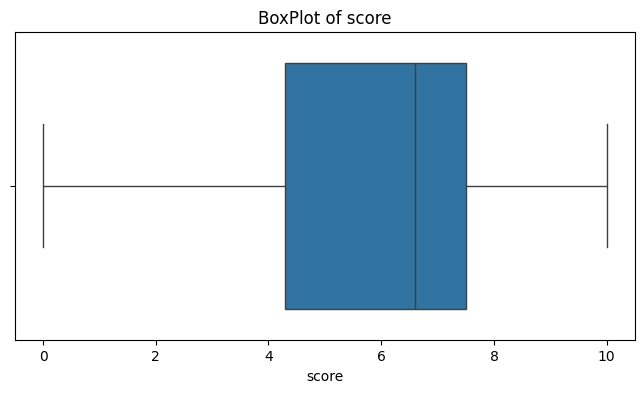

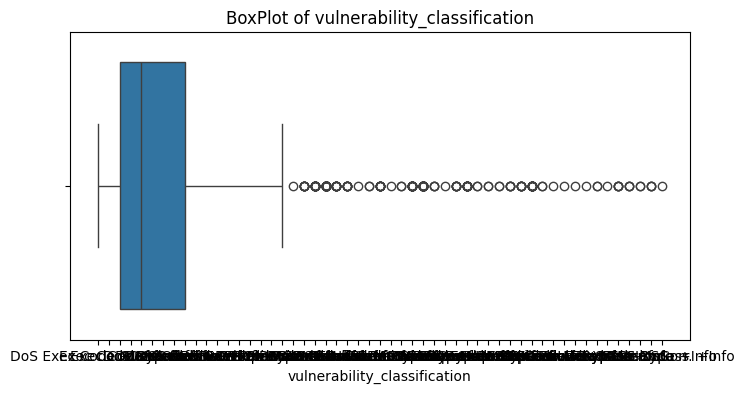

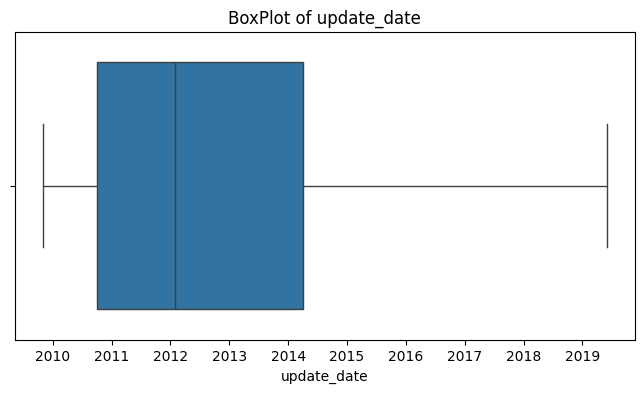

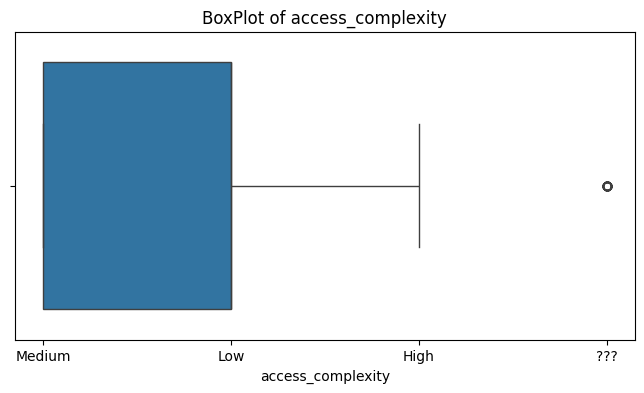

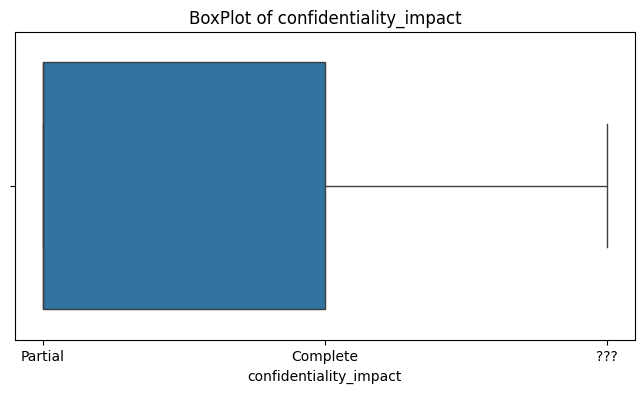

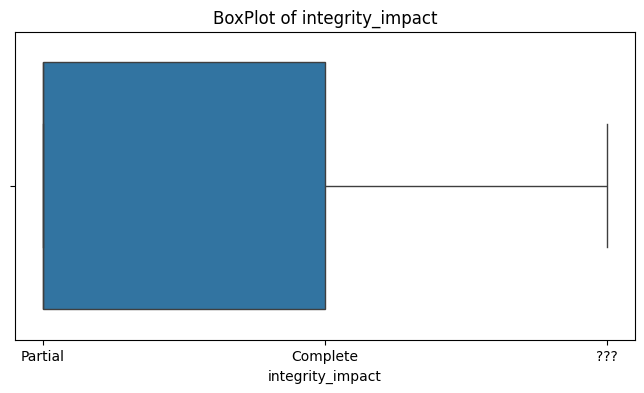

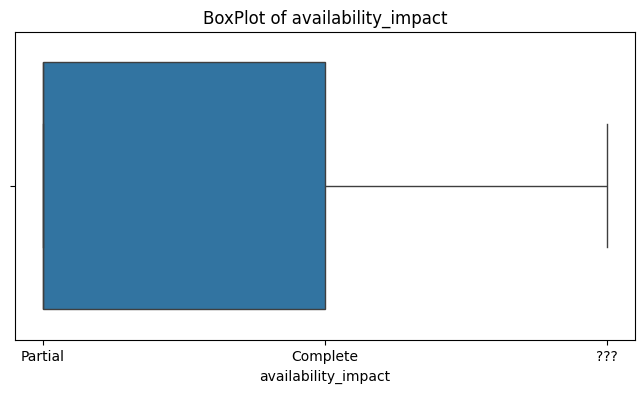

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols= ['score','vulnerability_classification',"severity",'update_date','access_complexity','confidentiality_impact',
           "integrity_impact",'availability_impact']
for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df[col])
        plt.title(f"BoxPlot of {col}")
        plt.show()

**Outlier Detection**

In [9]:
# Remove outliers using the IQR method
for col in num_cols:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Keep only rows within the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Outliers removed.")


Outliers removed.


Date Analysis

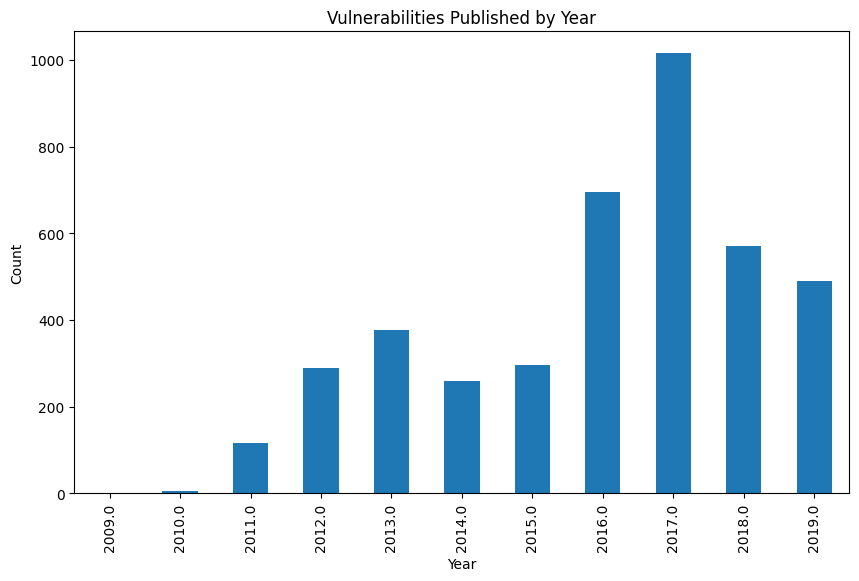

In [10]:
# Plot vulnerability publication over time
df['publish_year'] = df['publish_date'].dt.year
plt.figure(figsize=(10, 6))
df['publish_year'].value_counts().sort_index().plot(kind='bar')
plt.title('Vulnerabilities Published by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

**Data Visualization**

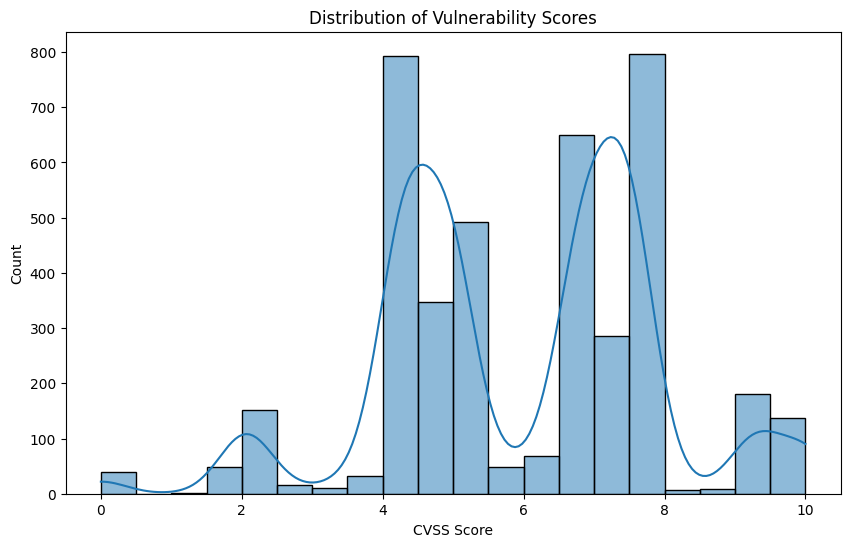

In [11]:
# Plot distribution of vulnerability scores
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], bins=20, kde=True)
plt.title('Distribution of Vulnerability Scores')
plt.xlabel('CVSS Score')
plt.ylabel('Count')
plt.show()

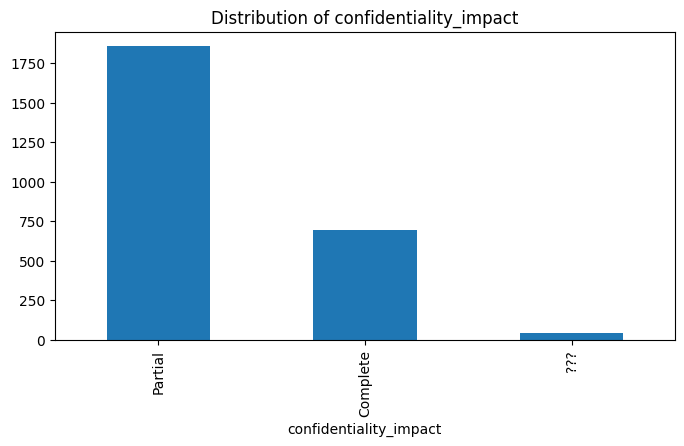

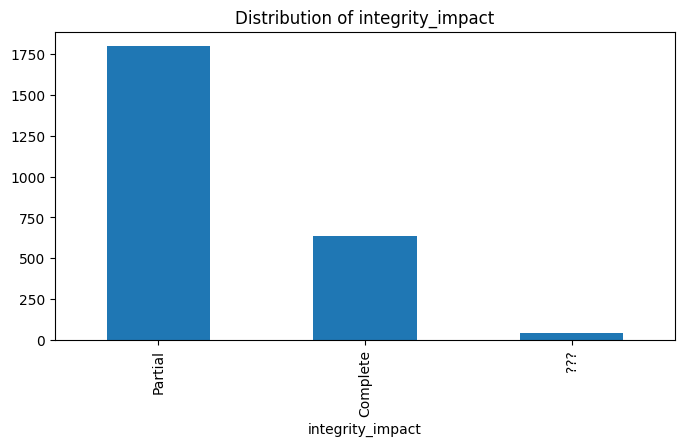

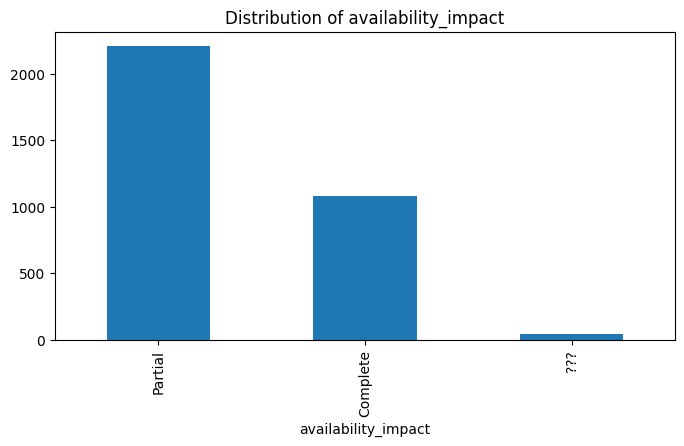

In [12]:
# Plot impact types
impact_cols = ['confidentiality_impact', 'integrity_impact', 'availability_impact']
for col in impact_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.show()

**Project Analysis**

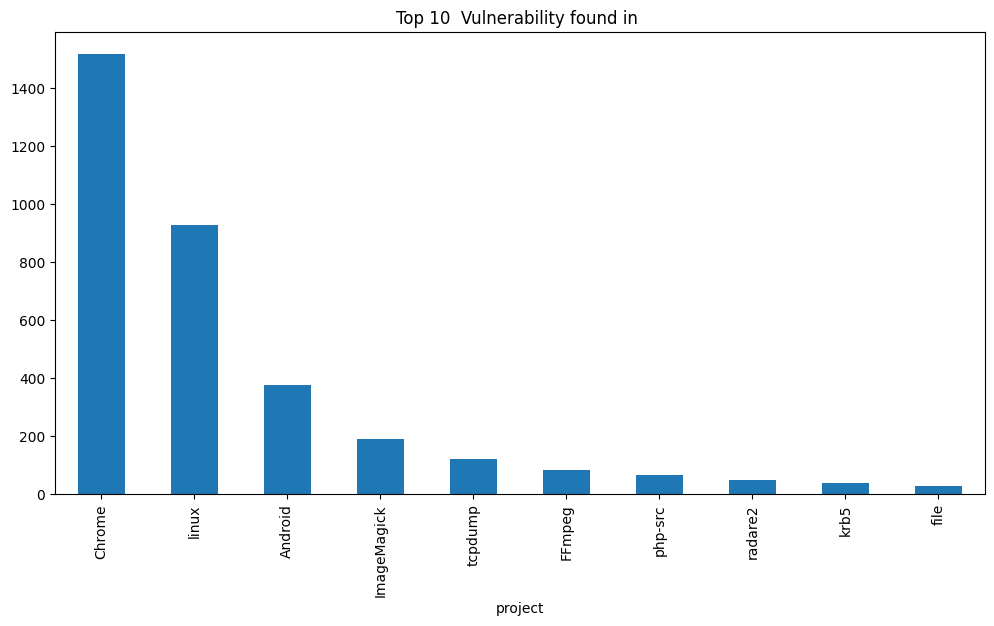

In [13]:
# Top projects with vulnerabilities
plt.figure(figsize=(12, 6))
df['project'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10  Vulnerability found in ')
plt.show()

Extract Features from JSON:

In [14]:
import ast
import json
import numpy as np  # Import numpy

def parse_files_changed(json_str):
    try:
        # Convert NaN to an empty string or dictionary
        if pd.isnull(json_str) or json_str == np.nan:  # Check for NaN using pd.isnull or np.nan
            return {}
        #If it's a string, try to parse it, otherwise, assume it's already parsed.
        if isinstance(json_str, str):
          data = ast.literal_eval(json_str)
        else:
          data = json_str
        if isinstance(data, dict):
            return data
        else:
            return {}  # Or handle other data types as needed
    except (SyntaxError, ValueError):
        try:
            data = json.loads(json_str)
            if isinstance(data, dict):
                return data
            else:
                return {}  # Or handle other data types as needed
        except json.JSONDecodeError:
            return {}  # Return empty dict for parsing failures

df['files_changed_parsed'] = df['files_changed'].apply(parse_files_changed)

df['num_files_changed'] = df['files_changed_parsed'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
df['file_extensions'] = df['files_changed_parsed'].apply(lambda x: list(set([v.get('filename', '').split('.')[-1] for v in x.values()])) if isinstance(x, dict) and all(isinstance(v, dict) for v in x.values()) else [])

**Categorize Scores**

In [15]:
# Categorize vulnerability scores
bins = [0, 4, 7, 9, 10]
labels = ['Low', 'Medium', 'High', 'Critical']
df['severity'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)

Final Clean Dataset

In [16]:
# Select columns to keep
final_columns = [
    'cve_id', 'cwe_id', 'publish_date', 'update_date', 'score', 'severity',
    'confidentiality_impact', 'integrity_impact', 'availability_impact',
    'access_complexity', 'vulnerability_classification', 'project',
    'lang', 'num_files_changed', 'file_extensions', 'summary'
]

clean_df = df[final_columns].copy()

# Save cleaned dataset
clean_df.to_csv('cleaned_vulnerabilities.csv', index=False)

In [17]:
import pandas as pd
df = pd.read_csv("cleaned_vulnerabilities.csv")
print(df.columns.tolist())  # List all column names

['cve_id', 'cwe_id', 'publish_date', 'update_date', 'score', 'severity', 'confidentiality_impact', 'integrity_impact', 'availability_impact', 'access_complexity', 'vulnerability_classification', 'project', 'lang', 'num_files_changed', 'file_extensions', 'summary']


In [18]:
import pandas as pd
from sklearn.utils import resample
print("Vulnerable samples:", df['cwe_id'].notna().sum())

# Create binary label column (1=vulnerable, 0=safe)
df['is_vulnerable'] = df['cwe_id'].notna().astype(int)

# Balance the dataset
vulnerable = df[df['is_vulnerable'] == 1]
safe = df[df['is_vulnerable'] == 0]

# Upsample vulnerable examples to match safe count
vulnerable_upsampled = resample(vulnerable,
                               replace=True,
                               n_samples=len(safe),
                               random_state=42)
balanced_df = pd.concat([safe, vulnerable_upsampled])

# Verify
print("Class balance after resampling:")
print(balanced_df['is_vulnerable'].value_counts())

Vulnerable samples: 3693
Class balance after resampling:
is_vulnerable
0    739
1    739
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "LightGBM": LGBMClassifier(boosting_type='gbdt', objective='binary'),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), early_stopping=True)
}

In [20]:
print("Actual columns in your DataFrame:")
print(df.columns.tolist())

Actual columns in your DataFrame:
['cve_id', 'cwe_id', 'publish_date', 'update_date', 'score', 'severity', 'confidentiality_impact', 'integrity_impact', 'availability_impact', 'access_complexity', 'vulnerability_classification', 'project', 'lang', 'num_files_changed', 'file_extensions', 'summary', 'is_vulnerable']


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Use the CORRECT text column (replace 'summary' with your actual column name)
text_column = 'summary'  # Change this to your actual column with code/text

# 1. Text Features
tfidf = TfidfVectorizer(max_features=500, stop_words=None)

# Handle NaN values in the 'summary' column before fitting TfidfVectorizer
balanced_df[text_column] = balanced_df[text_column].fillna('')  # Replace NaN with empty string

text_features = tfidf.fit_transform(balanced_df[text_column])  # Fixed here

# 2. Numeric Features
balanced_df['text_length'] = balanced_df[text_column].apply(len)  # Using text length as feature
numeric_features = balanced_df[['text_length']].values

# 3. Combine Features
X = hstack([text_features, numeric_features])
y = balanced_df['is_vulnerable']

# 4. Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes:
X_train: (1182, 501), y_train: (1182,)
X_test: (296, 501), y_test: (296,)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Initialize models (with error handling for failed fits)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "LightGBM": LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), early_stopping=True, random_state=42),

}

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=['Safe', 'Vulnerable']))
    except Exception as e:
        print(f"❌ {name} failed: {str(e)}")


--- Training Random Forest ---
              precision    recall  f1-score   support

        Safe       0.90      0.82      0.85       137
  Vulnerable       0.85      0.92      0.88       159

    accuracy                           0.87       296
   macro avg       0.87      0.87      0.87       296
weighted avg       0.87      0.87      0.87       296


--- Training SVM (RBF) ---
              precision    recall  f1-score   support

        Safe       1.00      0.47      0.64       137
  Vulnerable       0.69      1.00      0.82       159

    accuracy                           0.76       296
   macro avg       0.84      0.74      0.73       296
weighted avg       0.83      0.76      0.74       296


--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 580, number of negative: 602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

**Select the Best Model**

In [23]:
# Compare F1-scores (automated)
model_scores = {}
for name, model in models.items():
    if hasattr(model, 'predict'):  # Skip failed models
        y_pred = model.predict(X_test)
        model_scores[name] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

# Show ranked results
import pandas as pd
results_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['F1-Score'])
results_df = results_df.sort_values('F1-Score', ascending=False)
print("\n🏆 Model Rankings:")
print(results_df)


🏆 Model Rankings:
               F1-Score
XGBoost        0.888484
Random Forest  0.871016
LightGBM       0.861577
MLP            0.808043
SVM (RBF)      0.735860


** Hyperparameter Tuning (Best Model Only)bold text**

In [24]:
from sklearn.model_selection import GridSearchCV

# Select top model (e.g., XGBoost)
best_model_name = results_df.index[0]
best_model = models[best_model_name]

# Define parameter grid - Adjusted for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    # Removed 'learning_rate'
    # Added other relevant parameters for RandomForestClassifier
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Run grid search
grid = GridSearchCV(best_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

# Show best parameters
print(f"\n🔧 Best parameters for {best_model_name}:")
print(grid.best_params_)
print(f"Best F1: {grid.best_score_:.3f}")

c:\Users\dhass\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)



🔧 Best parameters for XGBoost:
{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1: 0.825


**Save & Test the Final Model**

In [25]:
import joblib

# Save the tuned model
final_model = grid.best_estimator_
joblib.dump(final_model, 'best_model.pkl')
# saving the

# Test prediction
test_sample = X_test[0:1]  # First test sample
pred = final_model.predict(test_sample)
prob = final_model.predict_proba(test_sample)[0][1]

print(f"\n🔍 Test Prediction:")
print(f"Class: {'Vulnerable' if pred[0] == 1 else 'Safe'}")
print(f"Probability: {prob:.2%}")


🔍 Test Prediction:
Class: Safe
Probability: 2.25%


***Next Steps Checklist***

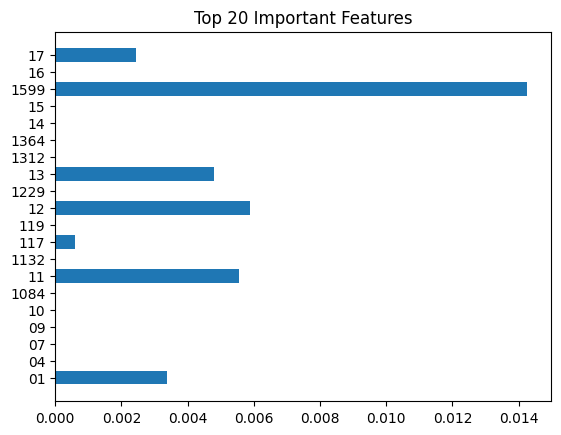

In [26]:
if hasattr(final_model, 'feature_importances_'):
    import matplotlib.pyplot as plt
    plt.barh(tfidf.get_feature_names_out()[:20], final_model.feature_importances_[:20])
    plt.title("Top 20 Important Features")

In [27]:
# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

**PKL MOdel Useage**

In [28]:
import joblib
import numpy as np
from scipy.sparse import hstack


# Load artifacts
model = joblib.load('best_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample test function
def predict_vulnerability(code_snippet):
    # 1. Transform features (same as training)
    text_features = tfidf.transform([code_snippet])
    num_features = np.array([[len(code_snippet)]])  # Same numeric features as training

    # 2. Combine features
    X = hstack([text_features, num_features])

    # 3. Predict
    proba = model.predict_proba(X)[0][1]  # Probability of being vulnerable
    is_unsafe = proba >= 0.5  # Threshold (adjust as needed)

    return {
        "code_snippet": code_snippet[:100] + "...",  # Preview
        "is_vulnerable": bool(is_unsafe),
        "probability": round(proba, 4),
        "confidence": "HIGH" if proba > 0.7 else "LOW"
    }

# Test with real code examples
test_cases = [
    "strcpy(buffer, input);",  # Unsafe
    "snprintf(buffer, sizeof(buffer), input);",  # Safer
    "system(user_input);",  # Unsafe
    "secure_encrypt(data, key);"  # Safe (hypothetical)
]

for code in test_cases:
    print(predict_vulnerability(code))

{'code_snippet': 'strcpy(buffer, input);...', 'is_vulnerable': True, 'probability': 0.9718, 'confidence': 'HIGH'}
{'code_snippet': 'snprintf(buffer, sizeof(buffer), input);...', 'is_vulnerable': True, 'probability': 0.9718, 'confidence': 'HIGH'}
{'code_snippet': 'system(user_input);...', 'is_vulnerable': True, 'probability': 0.7838, 'confidence': 'HIGH'}
{'code_snippet': 'secure_encrypt(data, key);...', 'is_vulnerable': True, 'probability': 0.881, 'confidence': 'HIGH'}


In [29]:
! pip install joblib numpy scipy requests ipython

In [30]:
import os
print(os.path.exists("best_model.pkl"))  # Should print True if the file is present


True


In [31]:
! pip install gitpython

In [ ]:
import joblib
import numpy as np
from scipy.sparse import hstack
import os
from collections import defaultdict

# Load the trained model and TF-IDF vectorizer
model = joblib.load('best_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')

# Common vulnerability patterns to look for
VULNERABILITY_PATTERNS = {
    'buffer_overflow': ['strcpy(', 'strcat(', 'gets(', 'sprintf(', 'memcpy(', 'strncpy(', 'strncat('],
    'command_injection': ['system(', 'popen(', 'exec(', 'ShellExecute('],
    'memory_issues': ['malloc(', 'free(', 'realloc(', 'memset('],
    'format_string': ['printf(', 'fprintf(', 'sprintf(', 'snprintf(']
}

def predict_vulnerability(code_snippet):
    """Predict if a code snippet is vulnerable using the trained model."""
    # Transform features
    text_features = tfidf.transform([code_snippet])
    num_features = np.array([[len(code_snippet)]])
    
    # Combine features
    X = hstack([text_features, num_features])
    
    # Predict
    proba = model.predict_proba(X)[0][1]
    
    # Check for known vulnerability patterns **after** model prediction
    detected_patterns = []
    for vuln_type, patterns in VULNERABILITY_PATTERNS.items():
        if any(pattern.lower() in code_snippet.lower() for pattern in patterns):
            detected_patterns.append(vuln_type)
    
    return {
        "code_snippet": code_snippet[:100] + ("..." if len(code_snippet) > 100 else ""),
        "is_vulnerable": proba >= 0.5,
        "probability": round(float(proba), 4),
        "confidence": "HIGH" if proba > 0.7 else ("MEDIUM" if proba > 0.5 else "LOW"),
        "vulnerability_types": detected_patterns if detected_patterns else None
    }

def analyze_file_content(content):
    """Analyze file content with model-based vulnerability classification."""
    lines = content.split('\n')
    results = []
    vulnerabilities = []
    vulnerability_stats = defaultdict(int)

    for i, line in enumerate(lines):
        if line.strip():  # Skip empty lines
            result = predict_vulnerability(line)
            results.append(result)
            if result['is_vulnerable']:
                vulnerabilities.append({
                    'line_number': i+1,
                    'code': line[:100] + ("..." if len(line) > 100 else ""),
                    'probability': result['probability'],
                    'confidence': result['confidence'],
                    'types': result['vulnerability_types']
                })
                for vuln_type in (result['vulnerability_types'] or []):
                    vulnerability_stats[vuln_type] += 1
    
    # Calculate overall file safety
    total_lines = len([l for l in lines if l.strip()])
    vulnerable_lines = len(vulnerabilities)
    safety_percentage = ((total_lines - vulnerable_lines) / total_lines) * 100 if total_lines > 0 else 100
    
    overall_status = "SAFE" if vulnerable_lines == 0 else ("MODERATE RISK" if safety_percentage > 80 else "HIGH RISK")
    status_emoji = "✅" if overall_status == "SAFE" else ("⚠️" if overall_status == "MODERATE RISK" else "❌")
    
    return {
        'total_lines': total_lines,
        'vulnerable_lines': vulnerable_lines,
        'safety_percentage': round(safety_percentage, 2),
        'overall_status': overall_status,
        'status_emoji': status_emoji,
        'status_description': f"{vulnerable_lines} potential vulnerabilities found" if vulnerable_lines else "No vulnerabilities detected",
        'vulnerabilities': vulnerabilities,
        'vulnerability_stats': dict(vulnerability_stats)
    }

def test_uploaded_file():
    """Analyze a local file for vulnerabilities."""
    file_path = input("Enter the file path: ").strip()
    if not os.path.exists(file_path):
        print("Error: File not found!")
        return
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        analysis = analyze_file_content(content)

        print(f"\n{analysis['status_emoji']} {analysis['overall_status']}: {analysis['status_description']}")
        print(f"Lines Analyzed: {analysis['total_lines']}")
        print(f"Potential Vulnerabilities Found: {analysis['vulnerable_lines']}")
        print(f"Safety Percentage: {analysis['safety_percentage']}%\n")
        
        if analysis['vulnerability_stats']:
            print("Vulnerability Type Breakdown:")
            for vuln_type, count in analysis['vulnerability_stats'].items():
                print(f"- {vuln_type.replace('_', ' ').title()}: {count}")
        
        if analysis['vulnerable_lines'] > 0:
            print("\nDetailed Vulnerability Report:")
            for vuln in analysis['vulnerabilities']:
                print(f"Line {vuln['line_number']}: {vuln['code']}")
                print(f"  Confidence: {vuln['confidence']} (Probability: {vuln['probability']})")
                if vuln['types']:
                    print(f"  Vulnerability Types: {', '.join(vuln['types'])}")
    except Exception as e:
        print(f"Error: {str(e)}")

def main_menu():
    """Display the main menu and handle user choice."""
    while True:
        print("="*50)
        print("CODE VULNERABILITY PREDICTOR")
        print("="*50)
        print("1. Test individual code snippets")
        print("2. Upload and analyze a file")
        print("3. Exit")
        choice = input("Enter your choice (1-3): ")
        if choice == '1':
            code_snippet = input("\nEnter code snippet: ")
            result = predict_vulnerability(code_snippet)
            print(f"\nResult: {result}")
        elif choice == '2':
            test_uploaded_file()
        elif choice == '3':
            print("\nExiting program. Goodbye!")
            break
        else:
            print("\nInvalid choice. Please try again.")

if __name__ == "__main__":
    main_menu()


CODE VULNERABILITY PREDICTOR
1. Test individual code snippets
2. Upload and analyze a file
3. Exit
